In [1]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# plotting
import matplotlib.pyplot as plt

# saving
import joblib

In [2]:
X_train = joblib.load('data/X_train_preprocessed.pkl')
X_test = joblib.load('data/X_test_preprocessed.pkl')
y_train = joblib.load('data/y_train_preprocessed.pkl')
y_test = joblib.load('data/y_test_preprocessed.pkl')

In [3]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [4]:
decision_tree = DecisionTreeClassifier(random_state=42)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [5]:
param_distributions = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(3, 20), # profundidade
    'min_samples_split': np.arange(2, 20),  # mínimo de amostras p divisao
    'min_samples_leaf': np.arange(1, 20),  # mínimo de amostras em cada folha
    'max_features': ['auto', 'sqrt', 'log2', None]  # núm de atributos a considerar
}

In [6]:
def train_random_search_decision_tree(X, y, estimator, grid):
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=grid, 
        cv=skf,  
        scoring=scoring, 
        refit='f1_macro',  
        n_jobs=-1,  
        return_train_score=True,  
        n_iter=20 
    )

    random_search.fit(X, y) 

    return random_search

In [7]:
def get_results_decision_tree(r_search):
    results = pd.DataFrame(r_search.cv_results_)
    
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_criterion', 'param_max_depth', 'param_min_samples_split', 
            'param_min_samples_leaf', 'param_max_features', 'mean_train_accuracy', 'mean_test_accuracy', 
            'rank_test_accuracy', 'mean_train_precision_macro', 'mean_test_precision_macro', 
            'rank_test_precision_macro', 'mean_train_recall_macro', 'mean_test_recall_macro', 
            'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]

    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [8]:
grid_search_dt = train_random_search_decision_tree(X_train, y_train, decision_tree, param_distributions)

c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.p

In [9]:
results_dt = get_results_decision_tree(grid_search_dt)
results_dt.head()

,mean_fit_time,mean_score_time,param_criterion,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
9,0.306499,0.023147,gini,8,12,14,None,0.883849,0.849934,3,0.814365,0.727684,3,0.719617,0.660011,1,0.753153,0.682984,1
1,0.183395,0.030601,gini,3,7,9,None,0.854820,0.853687,1,0.743743,0.739352,1,0.648319,0.644826,6,0.675865,0.671789,2
18,0.390397,0.019060,gini,11,11,12,None,0.897776,0.835955,6,0.837502,0.694179,6,0.761428,0.654542,2,0.791503,0.669600,3
11,0.415525,0.037554,gini,10,10,10,None,0.901281,0.834590,9,0.843936,0.690321,7,0.770496,0.649590,5,0.799795,0.664639,4
13,0.637451,0.027934,gini,12,8,6,None,0.924985,0.827255,11,0.884979,0.677847,8,0.828780,0.653468,3,0.853207,0.663422,5


In [ ]:
def view_test_metrics_decision_tree(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = [
        "param_criterion", "param_max_depth", "param_min_samples_split", 
        "param_min_samples_leaf", "param_max_features"
    ]

    plot_df = results_df.melt(
        id_vars=param_cols,     
        value_vars=metrics,      
        var_name="metric",       
        value_name="score"       
    )

    plt.figure(figsize=(12, 8))
    
    groups = list(plot_df.groupby(param_cols))
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    for i, (combo, group) in enumerate(groups):
        group = group.sort_values("metric")
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        color = colors[i]
        
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     color=color,
                     label=label_str + " (train)")
            
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     color=color,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics for Decision Tree")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

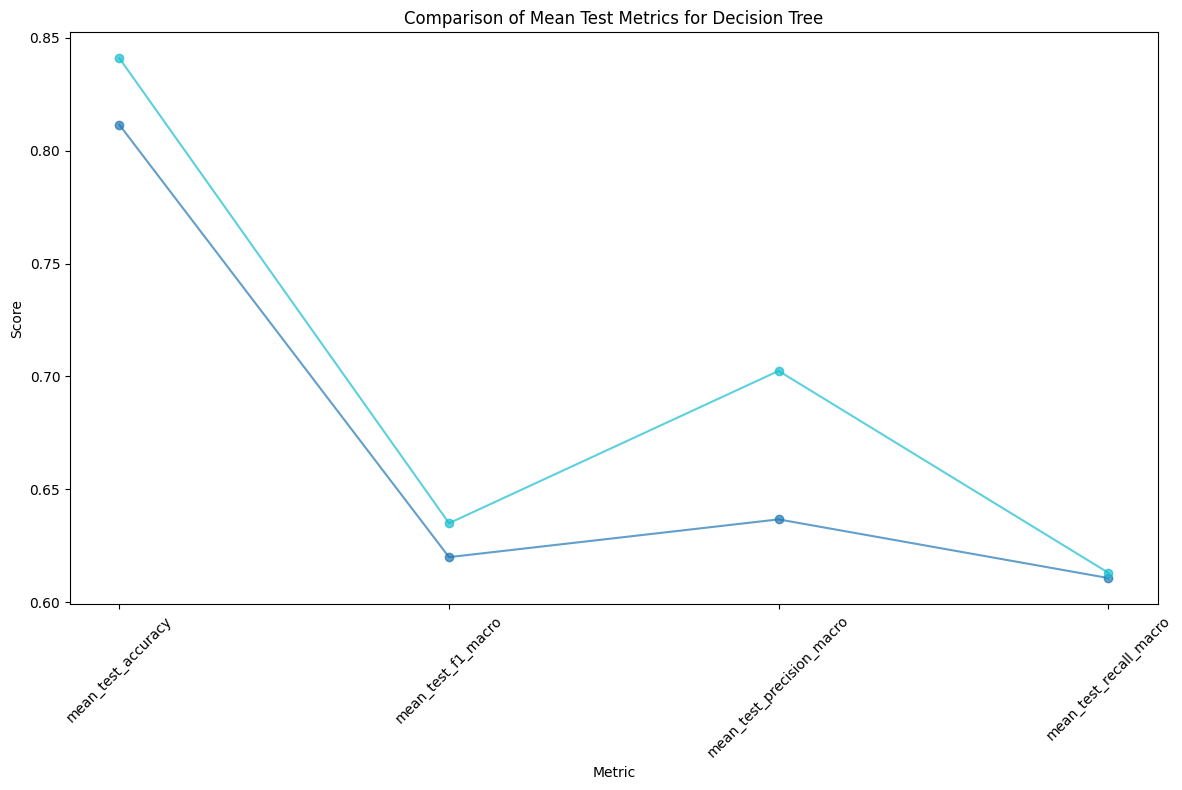

In [11]:
view_test_metrics_decision_tree(False, 10, results_dt)

In [12]:
def os_smote(X, y):
    smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    
    return X_balanced, y_balanced

In [ ]:
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))  # DecisionTreeClassifier
])

In [14]:
param_grid = [
    {
        'dt__criterion': ['gini', 'entropy'],
        'dt__max_depth': [3, 5, 10, 15, 20, None],
        'dt__min_samples_split': [2, 5, 10],  
        'dt__min_samples_leaf': [1, 2, 5, 10],  
        'dt__max_features': ['auto', 'sqrt', 'log2', None] 
    }
]

In [ ]:
def get_results_pipeline_decision_tree(g_search):
    results = pd.DataFrame(g_search.cv_results_)
   
    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_criterion', 'param_max_depth', 'param_min_samples_split',
            'param_min_samples_leaf', 'param_max_features', 'mean_train_accuracy', 'mean_test_accuracy', 
            'rank_test_accuracy', 'mean_train_precision_macro', 'mean_test_precision_macro', 
            'rank_test_precision_macro', 'mean_train_recall_macro', 'mean_test_recall_macro', 
            'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]
    
    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results


In [ ]:
def view_test_metrics_decision_tree(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    param_cols = [
        "param_criterion", "param_max_depth", "param_min_samples_split", 
        "param_min_samples_leaf", "param_max_features"
    ]

    plot_df = results_df.melt(
        id_vars=param_cols,     
        value_vars=metrics,      
        var_name="metric",       
        value_name="score"       
    )

    plt.figure(figsize=(12, 8))

    groups = list(plot_df.groupby(param_cols))
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    for i, (combo, group) in enumerate(groups):
        group = group.sort_values("metric")
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        color = colors[i]
        
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     color=color,
                     label=label_str + " (train)")

        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     color=color,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics for Decision Tree")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [17]:
random_search_dt = train_random_search_decision_tree(X_train, y_train, decision_tree, param_distributions)

c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.p

In [18]:
results_dt = get_results_pipeline_decision_tree(random_search_dt)

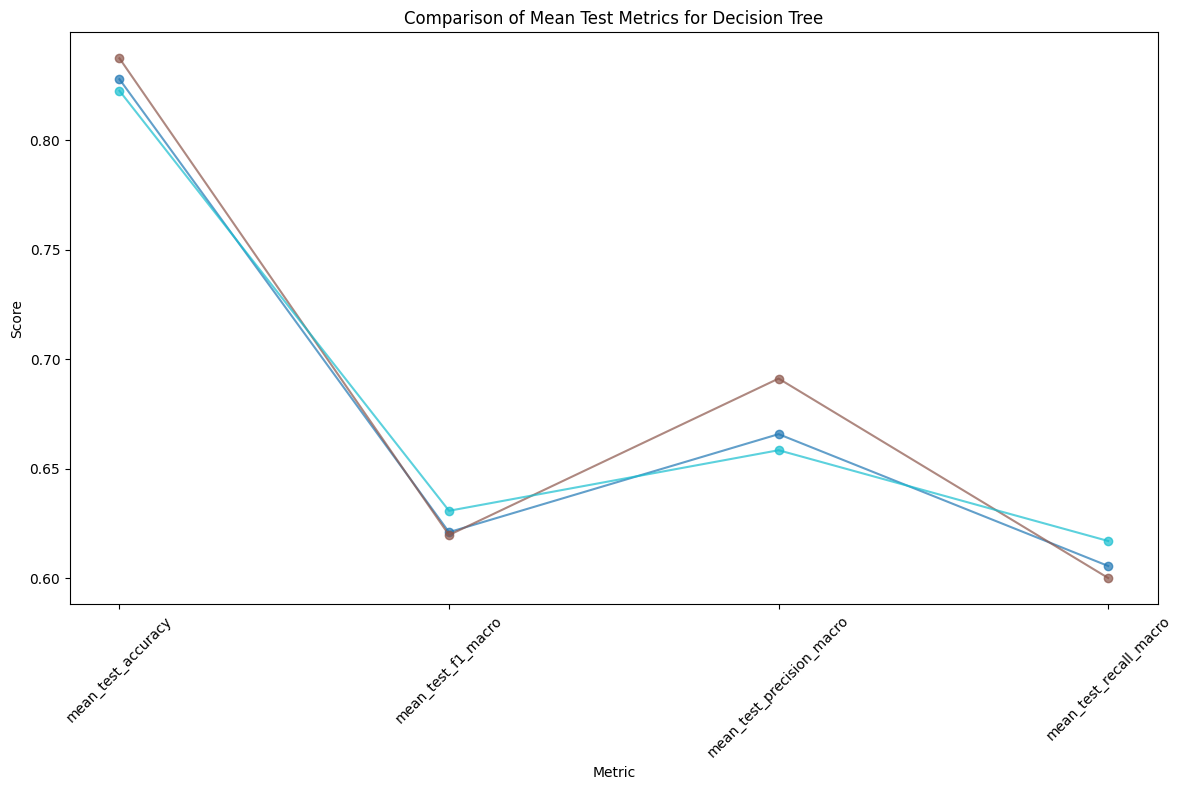

In [19]:
view_test_metrics_decision_tree(False, 10, results_dt)

In [ ]:
pipeline = Pipeline([
    ('oversampler', SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

In [21]:
grid_search = train_random_search_decision_tree(X_train, y_train, pipeline, param_grid)

c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\rafap\AppDa

In [ ]:
def get_results_pipeline_decision_tree(g_search):
    results = pd.DataFrame(g_search.cv_results_)

    results = results[
        [
            'mean_fit_time', 'mean_score_time', 'param_dt__criterion', 'param_dt__max_depth', 'param_dt__min_samples_split',
            'param_dt__min_samples_leaf', 'param_dt__max_features', 'mean_train_accuracy', 'mean_test_accuracy', 
            'rank_test_accuracy', 'mean_train_precision_macro', 'mean_test_precision_macro', 
            'rank_test_precision_macro', 'mean_train_recall_macro', 'mean_test_recall_macro', 
            'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
        ]
    ]
    
    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [ ]:
results = get_results_pipeline_decision_tree(grid_search)
results.head()

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_dt__min_samples_split', 'param_dt__min_samples_leaf',
       'param_dt__max_features', 'param_dt__max_depth', 'param_dt__criterion',
       'params',
       ...
       'split2_train_f1_macro', 'split3_train_f1_macro',
       'split4_train_f1_macro', 'split5_train_f1_macro',
       'split6_train_f1_macro', 'split7_train_f1_macro',
       'split8_train_f1_macro', 'split9_train_f1_macro', 'mean_train_f1_macro',
       'std_train_f1_macro'],
      dtype='object', length=110)


,mean_fit_time,mean_score_time,param_dt__criterion,param_dt__max_depth,param_dt__min_samples_split,param_dt__min_samples_leaf,param_dt__max_features,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
18,0.533038,0.025444,gini,3,10,1,None,0.778952,0.779513,14,0.661670,0.661779,2,0.734346,0.732525,1,0.678582,0.678443,1
10,0.557536,0.030698,gini,3,2,10,None,0.778952,0.779513,14,0.661670,0.661779,2,0.734346,0.732525,1,0.678582,0.678443,1
3,0.947211,0.025868,entropy,3,2,5,None,0.786077,0.780188,13,0.667608,0.662563,1,0.734319,0.724991,4,0.683225,0.675031,3
14,0.165463,0.033924,gini,3,10,2,sqrt,0.777115,0.777116,16,0.657177,0.657085,4,0.726549,0.726517,3,0.673901,0.673606,4
2,0.495713,0.033863,gini,10,2,1,sqrt,0.861812,0.781383,12,0.754230,0.647091,8,0.820465,0.695439,6,0.779139,0.661434,5


In [26]:
grid_search = train_random_search_decision_tree(X_train, y_train, pipeline, param_grid)

c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rafap\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\rafap\AppDa

In [27]:
results_dt = get_results_pipeline_decision_tree(grid_search)
results_dt.head(10)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_dt__min_samples_split', 'param_dt__min_samples_leaf',
       'param_dt__max_features', 'param_dt__max_depth', 'param_dt__criterion',
       'params',
       ...
       'split2_train_f1_macro', 'split3_train_f1_macro',
       'split4_train_f1_macro', 'split5_train_f1_macro',
       'split6_train_f1_macro', 'split7_train_f1_macro',
       'split8_train_f1_macro', 'split9_train_f1_macro', 'mean_train_f1_macro',
       'std_train_f1_macro'],
      dtype='object', length=110)


,mean_fit_time,mean_score_time,param_dt__criterion,param_dt__max_depth,param_dt__min_samples_split,param_dt__min_samples_leaf,param_dt__max_features,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
7,1.499003,0.031134,gini,10,10,2,None,0.901148,0.820603,1,0.820770,0.679741,1,0.822075,0.691055,4,0.820887,0.684681,1
8,0.146922,0.028771,gini,3,2,10,sqrt,0.777115,0.777116,13,0.657177,0.657085,2,0.726549,0.726517,1,0.673901,0.673606,2
3,0.309891,0.046853,gini,3,2,5,sqrt,0.777115,0.777116,13,0.657177,0.657085,2,0.726549,0.726517,1,0.673901,0.673606,2
9,0.195983,0.026399,entropy,10,10,10,log2,0.823556,0.784968,9,0.698903,0.647107,5,0.749137,0.687613,5,0.717198,0.659940,4
14,0.240853,0.039807,entropy,10,5,2,log2,0.837142,0.779515,11,0.721144,0.646933,6,0.779879,0.691900,3,0.741472,0.659554,5
0,0.508042,0.073017,gini,10,5,2,log2,0.846483,0.781560,10,0.732524,0.640369,8,0.790976,0.676842,6,0.754191,0.652312,6
12,1.931552,0.024255,gini,None,2,5,None,0.933094,0.803897,2,0.884437,0.648337,4,0.867890,0.652815,8,0.875794,0.649951,7
17,1.605687,0.022090,entropy,None,10,2,None,0.963772,0.803042,3,0.946356,0.643769,7,0.919358,0.645211,10,0.932117,0.644158,8
10,0.297716,0.034072,entropy,15,10,1,sqrt,0.925193,0.786842,6,0.863079,0.631324,9,0.867501,0.650139,9,0.865045,0.638804,9
15,1.600720,0.023574,entropy,20,5,1,None,0.990318,0.791785,5,0.986048,0.631143,10,0.978600,0.642216,11,0.982264,0.635998,10


In [ ]:
pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)) 
])

In [29]:
preds = cross_val_predict(pipeline, X_train, y_train, cv=skf, n_jobs=-1)

In [30]:
cm = confusion_matrix(y_train, preds)

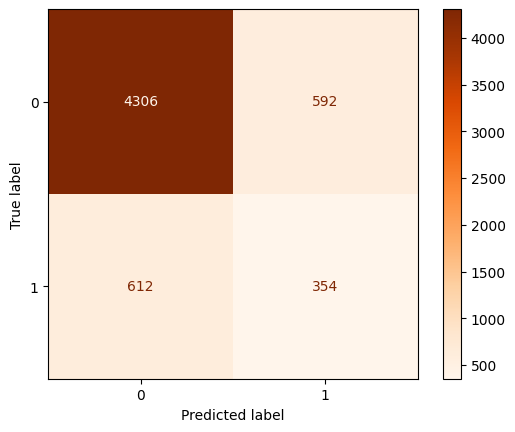

In [31]:
cmd = ConfusionMatrixDisplay(cm, display_labels=grid_search.best_estimator_.named_steps['dt'].classes_)
cmd.plot(cmap=plt.cm.Oranges)
plt.show()

In [32]:
print(classification_report(y_train, preds, digits=4))

              precision    recall  f1-score   support

           0     0.8756    0.8791    0.8773      4898
           1     0.3742    0.3665    0.3703       966

    accuracy                         0.7947      5864
   macro avg     0.6249    0.6228    0.6238      5864
weighted avg     0.7930    0.7947    0.7938      5864



In [33]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('oversampler', RandomOverSampler(random_state=42)),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [34]:
dt = pipeline.named_steps['dt']

In [ ]:
col_names = list(joblib.load('data/col_names.pkl'))

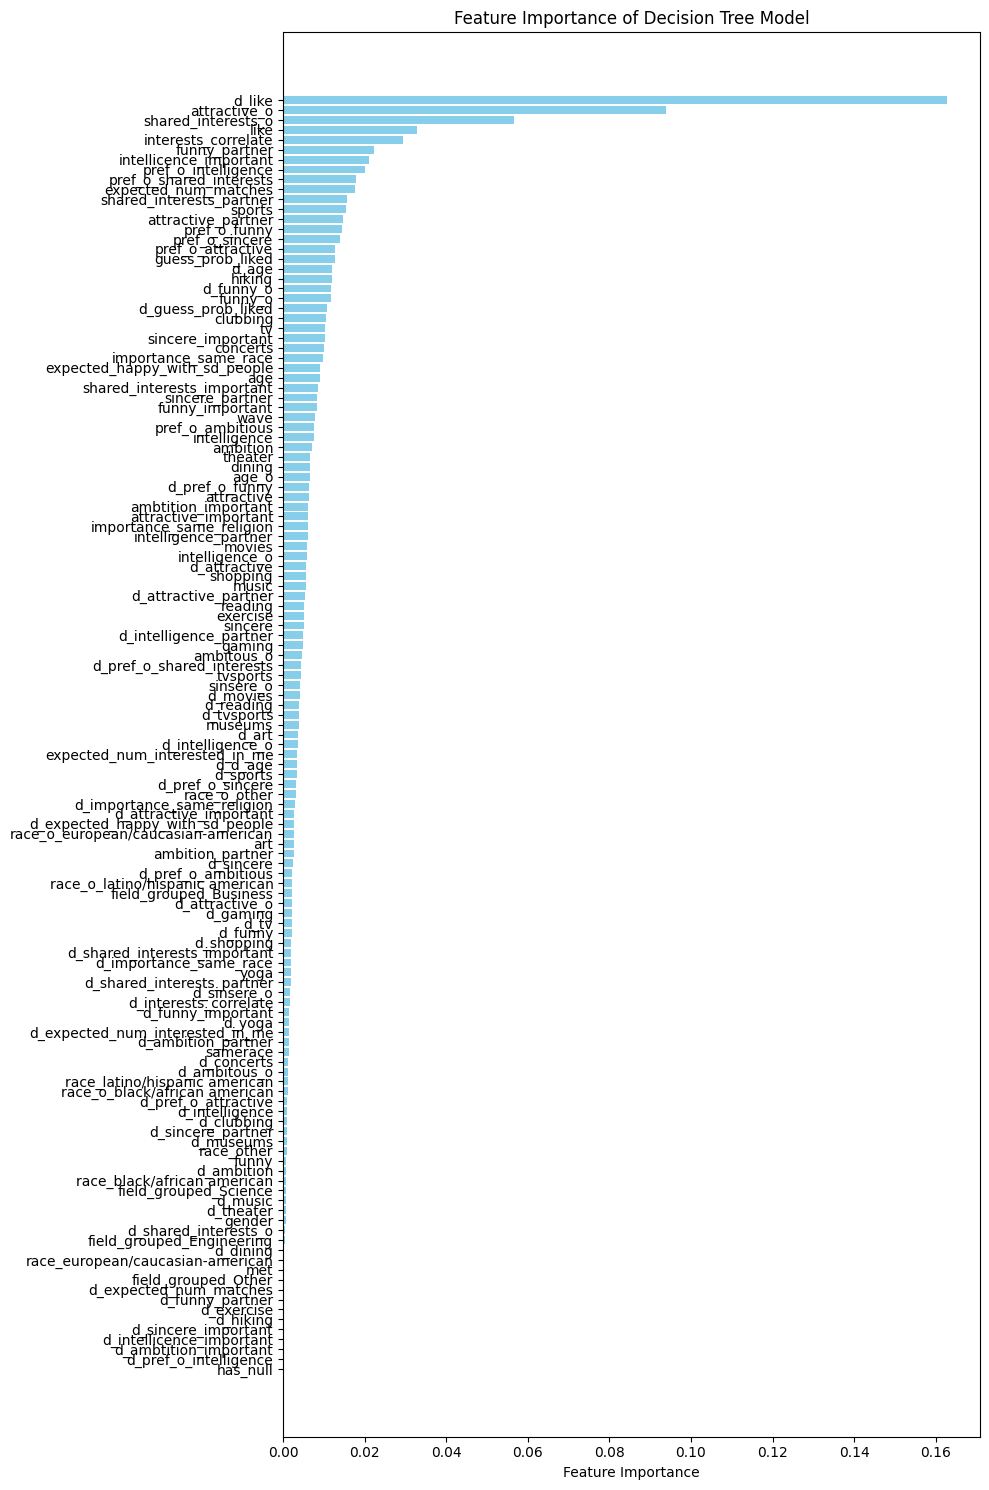

In [ ]:
importances = dt.feature_importances_.ravel().reshape(1, -1)
feature_importance = pd.DataFrame(data=importances, columns=col_names)

importance_series = feature_importance.iloc[0]
importance_series_sorted = importance_series.sort_values(ascending=True)

plt.figure(figsize=(10, 15))
plt.barh(importance_series_sorted.index, importance_series_sorted.values, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance of Decision Tree Model')
plt.tight_layout()
plt.show()

In [37]:
joblib.dump(pipeline.named_steps['dt'], 'models/dt.pkl')

['models/dt.pkl']